<a href="https://colab.research.google.com/github/coloshword/Seq2SeqTranslation/blob/master/benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Benchmarking nn.Linear vs nd.Linear in a Sequence To Sequence Machine Translation Model

## Overview
**This is my application to Ensemble AI's ML research intern & ML engineering intern positions**

We will develop and benchmark two English → Chinese sequence to sequence translators built on an LSTM encoder decoder with Luong (general) attention.
The models share the same data pipeline, tokenizer, training schedule, and hyper-parameters; they diverge only in the final output linear layer.

a. In the baseline (nn.Linear) model, we generate a context tensor through the attention mechanism, and concatenate the context tensor to the end of the hidden state tensor. This results in a linear layer with parameters: **nn.Linear(2 * hidden_dim, vocab_size)**.

- Weights parameter count: $$
2 H × V
$$

b. In the NdLinear version, we take advantage of NdLinear's strength for multidimensional inputs, and treat the context tensor as another row, resulting in an input of shape (2, hidden_dim). This results in a linear layer **NdLinear((2, hidden_dim), (1, vocab_size))**, which is **~50%** the parameters of the standard linear layer.
- Weights parameter count:
$$
(2 * 1) + (H * V)
$$


We will benchmark the performance of the standard Seq2Seq model to this augmented model using NdLinear, and see how the smaller NdLinear model performs, compared to the larger standard model.

### Imports

In [ ]:
import json
import numpy as np
import pickle
from collections import Counter
import string
import re
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
from ndlinear import NdLinear

In [ ]:
### Loading colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
## root will be added to all paths, to work with drive
root = '/content/drive/MyDrive/Seq2SeqModelBenchmarking/' # for colab

# root = '' # for local training

Mounted at /content/drive


### Dataset & Preprocessing

Full Dataset: (https://www.kaggle.com/datasets/qianhuan/translation?resource)
- 5.1M English-Chinese sentence pairs
- For the sake of the experiment, we will randomly sample 250,000 pairs
- also sample 5000 pairs from validation set

In [ ]:
train_set_path = root + "dataset/translation2019zh_train.json"
val_set_path = root + "dataset/translation2019zh_valid.json"
train_set = []
val_set = []

with open(train_set_path) as f:
    for line in f:
        train_set.append(json.loads(line))

with open(val_set_path) as f:
    for line in f:
        val_set.append(json.loads(line))

print(len(train_set))
print(train_set[0])

5161434
{'english': 'For greater sharpness, but with a slight increase in graininess, you can use a 1:1 dilution of this developer.', 'chinese': '为了更好的锐度，但是附带的会多一些颗粒度，可以使用这个显影剂的1：1稀释液。'}


In [ ]:
### sample 250,000 sentences and save the data
sampled_indices = np.random.choice(len(train_set), 250000)

train_subset = [train_set[i] for i in sampled_indices]
print(train_subset[0])
with open(root + 'dataset/train_set_mini.pkl', 'wb') as f:
    pickle.dump(train_subset, f)

## sample 5000 pairs for validation set
val_sampled_indices = np.random.choice(len(val_set), 5000)
val_subset = [val_set[i] for i in val_sampled_indices]

with open(root + 'dataset/val_set_mini.pkl', 'wb') as f:
    pickle.dump(val_subset, f)


{'english': 'House prices will fall just 3 percent more before stabilizing, or 33 percent from the peak in mid-2006, based on the median forecast.', 'chinese': '预估中值显示,房价止稳前仅有3%的下跌空间,与2006年年中的峰值相较为下跌33%.'}


In [ ]:
## pull the subset dataset
with open(root + 'dataset/train_set_mini.pkl', 'rb') as f:
    train_set_mini = pickle.load(f)

with open(root + 'dataset/val_set_mini.pkl', 'rb') as f:
    val_set_mini = pickle.load(f)

print(train_set_mini[0])
print(val_set_mini[0])

{'english': 'House prices will fall just 3 percent more before stabilizing, or 33 percent from the peak in mid-2006, based on the median forecast.', 'chinese': '预估中值显示,房价止稳前仅有3%的下跌空间,与2006年年中的峰值相较为下跌33%.'}
{'english': 'However, it contains the contradiction of good producing evil, which gave rise to the dualism of nature from ZHANG Zai to ZHU Xi, a relatively perfect solution to LIs problem.', 'chinese': '但是，李翱的人性论中包含着善性产生邪情的矛盾，正是对这一矛盾的解答引发了宋明性二元论的诞生。'}


### Creating vocabularies:
- Maintain a vocabulary for english and chinese.
- Limit it to words that appear at least 5 times.
- Sequences will be represented as a list of indices, in the order in which they appear in the sentence, e.g. [0, 98, 4532, 12, 1].
- These list of sequences will be passed to their appropriate embedding layer.

In [ ]:
def remove_punctuation(text):
    '''
    Get rid of all punctuation from string text
    '''
    return text.translate(str.maketrans('', '', string.punctuation))

def get_words_from_sentence(s):
    '''
    Gets words from sentence
    '''
    return s.split(' ')

def clean_en_pair(pair):
    '''
    Cleans the english from the pair
    '''
    return get_words_from_sentence(remove_punctuation(pair['english']).lower())

def remove_zh_punctuation(text):
    cleaned = re.sub(r'[，。！？【】（）《》“”‘’、]', '', text)
    cleaned = re.sub(r'\s+', '', cleaned)
    return cleaned

In [ ]:
def get_en_vocab(train_set):
    '''
    get_en_dict:
        Gets an english vocab from train_set as a dict
    '''
    # get only the english sentences, list of strings
    en_sentences = [clean_en_pair(pair) for pair in train_set]
    en_sentences_flattened = [word for sentence in en_sentences for word in sentence]
    en_sentences_flattened = [word for word in en_sentences_flattened if word != '']

    word_counts = Counter(en_sentences_flattened)
    # with word counts, now we limit the vocabulary to words that happen at least 5 times
    en_vocab = {}
    # {word: index}
    idx = 0
    for word in ["<SOS>", "<EOS>", "<UNK>"]:
        en_vocab[word] = idx
        idx += 1
    for word, occurrences in word_counts.items():
        if occurrences >= 5:
            en_vocab[word] = idx
            idx += 1
    return en_vocab

def get_zh_vocab(train_set):
    '''
    get_zh_vocab:
        Gets an zh vocab from train_set as a dict
    '''
    zh_sentences = [list(remove_zh_punctuation(pair['chinese'])) for pair in train_set]
    zh_sentences_flattened = [word for sentence in zh_sentences for word in sentence]

    word_counts = Counter(zh_sentences_flattened)
    zh_vocab = {}

    idx = 0
    for word in ["<SOS>", "<EOS>", "<UNK>"]:
        zh_vocab[word] = idx
        idx += 1
    for word, occurrences in word_counts.items():
        if occurrences >= 2:
            zh_vocab[word] = idx
            idx += 1
    return zh_vocab

en_vocab = get_en_vocab(train_set_mini)
print(len(en_vocab))

zh_vocab = get_zh_vocab(train_set_mini)
print(len(zh_vocab))

36350
5818


In [ ]:
with open(root + 'vocab/en_vocab.pkl', 'wb') as f:
    pickle.dump(en_vocab, f)

with open(root + 'vocab/zh_vocab.pkl', 'wb') as f:
    pickle.dump(zh_vocab, f)

In [ ]:
with open(root + 'vocab/en_vocab.pkl', 'rb') as f:
    en_vocab = pickle.load(f)

with open(root + 'vocab/zh_vocab.pkl', 'rb') as f:
    zh_vocab = pickle.load(f)

## Model Architecture
- Based mostly on : (https://arxiv.org/pdf/1409.3215), not completely honest to the paper
- Model will consist of an Encoder and Decoder, passing in source sequence to encoder, and passing the hidden states from the encoder to the decoder.

**Encoder**:
- consists of an LSTM and an embedding layer.

**Decoder**:
- consists of an LSTM, an embedding layer, and a **linear layer** to output logits.
- this linear layer is where we can place nd.Linear in place of nn.Linear
- forward() has two settings, inference and teacher-forcing. If a "correct label" sentence is passed to the forward() function, it will do teacher forcing.

**Attention Layer**:
- A separate linear matrix to form form the weights of Luong attention.


### Model Classes

In [ ]:
class Encoder(nn.Module):
    def __init__(self, embedding_dim, vocab_size, hidden_dim):
        super(Encoder, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.LSTM = nn.LSTM(embedding_dim, hidden_dim) # initialize an LSTM, with embedding_dim, and hidden_dim hyperparameters

    def forward(self, sentence):
        embeds = self.embeddings(sentence)  # remember that sentence has to the in [word_index0, word_index1, word_index2] form
        out , (h_n, c_n) = self.LSTM(embeds.view(len(sentence), 1, -1)) # one timestep at a time
        return out, (h_n, c_n)

In [ ]:
### LUONG ATTENTION LAYER
class GeneralAttention(nn.Module):
    def __init__(self, hidden_dim, linear_cls=nn.Linear):
        super().__init__()
        self.linear_layer = linear_cls(hidden_dim, hidden_dim, bias=False)

    def forward(self, encoder_outputs):
        return self.linear_layer(encoder_outputs)

In [ ]:
class LuongAttnDecoder(nn.Module):
    def __init__(self, embedding_dim, vocab_size, hidden_dim, device, max_response_length, linear_layer):
        super(LuongAttnDecoder, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.LSTM = nn.LSTM(embedding_dim, hidden_dim)
        self.linear = linear_layer
        self.device = device
        self.general_attn_layer = GeneralAttention(hidden_dim)
        self.max_response_length = max_response_length

    def word_to_tensor(self, word):
        '''
        takes a single wrod and gets the corresponding tensor
        '''
        word_lst = get_words_from_sentence(remove_zh_punctuation(word))
        indices = [zh_vocab[word] for word in word_lst]
        # get tensor
        return torch.tensor(indices, dtype=torch.long).to(self.device)

    def forward(self, hidden, encoder_out, sentence=None):
        '''
        does the forward propagation. If sentence is provided, then we do teacher-forcing. Else we assume it is inference
            Params:
                hidden: the hidden state passed from the previous
                sentence: a sentence to be used for teacher-forcing, as a tensor
                Make sure the teacher-forcing sentence is sliced to not include the last token [:-1]
        '''
        # teacher-forcing training, we are going to "undo" vectorization]
        all_outputs = []
        if sentence is not None:
            embeds_tensor = self.embeddings(sentence)
            for word_tensor in embeds_tensor:
                out, hidden = self.LSTM(word_tensor.view(1, 1, -1), hidden)
                # pass encoder out to attention layer
                attn_scores = self.general_attn_layer(encoder_out) @ hidden[0].squeeze()
                # now with attn scores, we want to softmax the scores
                softmaxed_scores = torch.nn.functional.softmax(attn_scores, dim=0)
                # multiply by encoder_out
                # now that they are softmaxed, we want to multiply by all encoder states to give a weighted tensor, we can broadcast it as well
                weighted_encoder_hidden_states = softmaxed_scores * encoder_out.squeeze()
                # sum the tensor
                context = torch.sum(weighted_encoder_hidden_states, dim=0).view(1, 1, -1)
                # concat the context vector with the hidden state
                combined_tensor = torch.concat([context, hidden[0]], dim=-1)
                logits = self.linear(combined_tensor)
                all_outputs.append(logits)
        else:
            start_token = self.word_to_tensor('<SOS>')
            # run through embedding layer
            prev_char = start_token
            for i in range(self.max_response_length):
                if prev_char.item() == 1:
                    break
                embeds = self.embeddings(prev_char).to(self.device)
                out, hidden = self.LSTM(embeds.view(1, 1, -1), hidden)
                attn_scores = self.general_attn_layer(encoder_out) @ hidden[0].squeeze()
                softmaxed_scores = torch.nn.functional.softmax(attn_scores, dim=0)
                weighted_encoder_hidden_states = softmaxed_scores * encoder_out.squeeze()
                context = torch.sum(weighted_encoder_hidden_states, dim=0).view(1, 1, -1)
                combined_tensor = torch.concat([context, hidden[0]], dim=-1)
                logits = self.linear(combined_tensor)
                all_outputs.append(logits)
                pred_idx = torch.argmax(logits, dim=2).item()
                prev_char = torch.tensor(pred_idx, dtype=torch.long, device=self.device)
        return torch.cat(all_outputs, dim=0)

### Training / Inference utility functions

In [ ]:
## functions to take a sentence and turn it into a tensor, adding <sos> and <eos>
def sequence_to_tensor_en(sequence):
    '''
    takes sequence and converts to tensor
    '''
    # add "<SOS> and <EOS>"
    words = get_words_from_sentence("<SOS> " + remove_punctuation(sequence).lower() + " <EOS>")

    # convert to indices, reverting to <UNK> token
    word_indices = [ en_vocab[word] if word in en_vocab else en_vocab["<UNK>"] for word in words ]
    return torch.tensor(word_indices, dtype=torch.long)


def sequence_to_tensor_zh(sequence):
    '''
    takes sequence and converts to chinese tensor
    '''
    words = (["<SOS>"] + list(remove_zh_punctuation(sequence)))
    words.append("<EOS>")

    word_indices = [ zh_vocab[word] if word in zh_vocab else zh_vocab["<UNK>"] for word in words ]
    return torch.tensor(word_indices, dtype=torch.long)

def zh_tensor_outputs_to_sentence(output_tensor):
    '''
    converts a zh_tensor to a string
    '''
    s = ''
    zh_vocab_lst = list(zh_vocab.keys())
    for word_tensor in output_tensor:
        pred_idx = torch.argmax(word_tensor, dim=-1).item()
        s += zh_vocab_lst[pred_idx]
    return s

In [ ]:
def train(num_epochs, training_data, encoder, decoder, device, save_loss_file, lr=0.001):
    optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()), lr=lr
)
    count = 0
    total_loss = 0
    # see random prediction
    predict_en_sequence = "I love bread"
    predict_en_tensor = sequence_to_tensor_en(predict_en_sequence).to(device)
    out, predict_hidden = encoder(predict_en_tensor)
    out = out.to(device)
    print(zh_tensor_outputs_to_sentence(decoder.forward(predict_hidden, encoder_out=out)))

    ## calculate start loss:
    first_pair = training_data[0]
    english = first_pair['english']
    zh = first_pair['chinese']
    en_tensor = sequence_to_tensor_en(english).to(device)
    zh_tensor = sequence_to_tensor_zh(zh).to(device)

    out, hidden = encoder.forward(en_tensor)
    target = zh_tensor[1:]
    predicted = decoder.forward(hidden, encoder_out=out, sentence=zh_tensor[:-1])

    loss = nn.functional.cross_entropy(torch.squeeze(predicted), target)
    print(f"Number of trains {count}")
    print(f"Loss {loss.item()}")
    with open(save_loss_file, 'a') as f:
      f.write(f'{loss.item()}, {count} \n')
    start_time = time.time()
    for i in range(num_epochs):
        for pair in training_data:
            count += 1
            if count % 10000 == 0:
                # add the loss with count to it
                with open(save_loss_file, 'a') as f:
                     f.write(f'{total_loss / 10000}, {count} \n')
                total_loss = 0
            english = pair['english']
            zh = pair['chinese']
            en_tensor = sequence_to_tensor_en(english)
            zh_tensor = sequence_to_tensor_zh(zh)
            # pass to device
            en_tensor = sequence_to_tensor_en(english).to(device)
            zh_tensor = sequence_to_tensor_zh(zh).to(device)

            out, hidden = encoder.forward(en_tensor)
            target = zh_tensor[1:]
            predicted = decoder.forward(hidden, encoder_out=out, sentence = zh_tensor[:-1])
            loss = nn.functional.cross_entropy(torch.squeeze(predicted), target)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        out, predict_hidden = encoder(predict_en_tensor)
        out = out.to(device)
        print(zh_tensor_outputs_to_sentence(decoder.forward(predict_hidden, out)))
    print(f"Total training time: {time.time() - start_time}")

### Setting hyperparameters

In [ ]:
MAX_RESPONSE_LENGTH=20
EMBEDDING_DIM=32
HIDDEN_DIM=128
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

## EXPERIMENT: Performance benchmarking

- Train two Seq2Seq models that are identical in every respect except for the decoder's final projection layer.
  1. Baseline uses nn.Linear
  2. NdLinear variant uses NdLinear, and is a smaller linear layer.

Hidden dimensions, optimiser settings, training data, and number of epochs are held constant so any performance difference can be attributed solely to the output linear layer.


**NOTE**: During training I log a moving-average of training loss every 10 k steps; I skip validation loss to save runtime, since I didn't have any time to spare during training because I was unaware of the moved deadline. We save validation set performance to after both models have been trained.

### Baseline model (nn.Linear)

In [ ]:
## check colab gpu
!nvidia-smi

Thu May  1 01:06:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
encoder = Encoder(embedding_dim=32, vocab_size=len(en_vocab), hidden_dim=128)
linear_layer = nn.Linear(HIDDEN_DIM * 2, len(zh_vocab))
decoder = LuongAttnDecoder(embedding_dim=32, vocab_size=len(zh_vocab), hidden_dim=128, device=device, max_response_length=MAX_RESPONSE_LENGTH, linear_layer=linear_layer)
print(device)
encoder.to(device)
decoder.to(device)
save_loss_file = root + "intermediate_steps/experiment1-baseline.txt"
train(3, train_set_mini, encoder, decoder, device, save_loss_file)
torch.save(encoder.state_dict(), root + 'trained_models/experiment1_baseline_encoder.pth')
torch.save(decoder.state_dict(), root + 'trained_models/experiment2_baseline_decoder.pth')

cuda
玩石忆跋匈沸禹锯勲榻讷讷蒴蒴蒴咳讶搐玩石
Number of trains 0
Loss 8.679813385009766
Number of trains 10000
Loss 5.9435648654699325
Number of trains 20000
Loss 5.348671986603737
Number of trains 30000
Loss 5.137021565628052
Number of trains 40000
Loss 5.006373838460445
Number of trains 50000
Loss 4.900856076061726
Number of trains 60000
Loss 4.843751321041584
Number of trains 70000
Loss 4.786635821342468
Number of trains 80000
Loss 4.729067821955681
Number of trains 90000
Loss 4.702692483878136
Number of trains 100000
Loss 4.638772855591774
Number of trains 110000
Loss 4.621080605620146
Number of trains 120000
Loss 4.588877385520935
Number of trains 130000
Loss 4.5763243444442745
Number of trains 140000
Loss 4.53042227088213
Number of trains 150000
Loss 4.518346245837211
Number of trains 160000
Loss 4.494908419442177
Number of trains 170000
Loss 4.477072837495804
Number of trains 180000
Loss 4.469467745304108
Number of trains 190000
Loss 4.444072333800793
Number of trains 200000
Loss 4.410186759138107


### NdLinear approach
- To take advantage of nd.Linear's strength at multi-dimensional inputs, we change how the context vector is concatenated to the current hidden state. In the original structure, the context vector is essentially just appended to the hidden state, requiring the final linear layer to be (2 * hidden_dim, vocab_size). This presents an easy way to reshape the input tensor to take advantage of NdLinear's strength, by making the output linear layer, an NdLinear layer with input dimensions ((2, hidden_dim)). Hidden dim would have to stay (, vocab size) to map back into words, but needs to be (vocab_size, 1) to satisfy same number of axes. We define the decoder again, but with a slight change to flatten during the output stage.

In [ ]:
class NdLinearLuongAttnDecoder(nn.Module):
    def __init__(self, embedding_dim, vocab_size, hidden_dim, device, max_response_length, linear_layer):
        super(NdLinearLuongAttnDecoder, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.LSTM = nn.LSTM(embedding_dim, hidden_dim)
        self.linear = linear_layer
        self.device = device
        self.general_attn_layer = GeneralAttention(hidden_dim)
        self.max_response_length = max_response_length
        self.hidden_dim = hidden_dim

    def word_to_tensor(self, word):
        '''
        takes a single wrod and gets the corresponding tensor
        '''
        word_lst = get_words_from_sentence(remove_zh_punctuation(word))
        indices = [zh_vocab[word] for word in word_lst]
        # get tensor
        return torch.tensor(indices, dtype=torch.long).to(self.device)

    def forward(self, hidden, encoder_out, sentence=None):
        '''
        does the forward propagation. If sentence is provided, then we do teacher-forcing. Else we assume it is inference
            Params:
                hidden: the hidden state passed from the previous
                sentence: a sentence to be used for teacher-forcing, as a tensor
                Make sure the teacher-forcing sentence is sliced to not include the last token [:-1]
        '''
        # teacher-forcing training, we are going to "undo" vectorization]
        all_outputs = []
        if sentence is not None:
          embeds_tensor = self.embeddings(sentence)
          for word_tensor in embeds_tensor:
            out, hidden = self.LSTM(word_tensor.view(1, 1, -1), hidden)
            # pass encoder out to attention layer
            attn_scores = self.general_attn_layer(encoder_out) @ hidden[0].squeeze()
            # now with attn scores, we want to softmax the scores
            softmaxed_scores = torch.nn.functional.softmax(attn_scores, dim=0)
            # multiply by encoder_out
            # now that they are softmaxed, we want to multiply by all encoder states to give a weighted tensor, we can broadcast it as well
            weighted_encoder_hidden_states = softmaxed_scores * encoder_out.squeeze()
            # sum the tensor
            context = torch.sum(weighted_encoder_hidden_states, dim=0).view(1, 1, -1)
            # concat the context vector with the hidden state
            combined_tensor = torch.cat([context, hidden[0]], dim=-1)   # (1,1,2h)
            multi_axis = combined_tensor.view(1, 2, self.hidden_dim)

            logits = self.linear(multi_axis)
            all_outputs.append(logits)
        else:
            start_token = self.word_to_tensor('<SOS>')
            # run through embedding layer
            prev_char = start_token
            for i in range(self.max_response_length):
                if prev_char.item() == 1:
                    break
                embeds = self.embeddings(prev_char).to(self.device)
                out, hidden = self.LSTM(embeds.view(1, 1, -1), hidden)
                attn_scores = self.general_attn_layer(encoder_out) @ hidden[0].squeeze()
                softmaxed_scores = torch.nn.functional.softmax(attn_scores, dim=0)
                weighted_encoder_hidden_states = softmaxed_scores * encoder_out.squeeze()
                context = torch.sum(weighted_encoder_hidden_states, dim=0).view(1, 1, -1)
                combined_tensor = torch.cat([context, hidden[0]], dim=-1)   # (1,1,2h)
                multi_axis = combined_tensor.view(1, 2, self.hidden_dim)

                logits = self.linear(multi_axis)
                all_outputs.append(logits)
                pred_idx = torch.argmax(logits, dim=2).item()
                prev_char = torch.tensor(pred_idx, dtype=torch.long, device=self.device)
        return torch.cat(all_outputs, dim=0)

### NdLinear train

In [ ]:
## define the 2d input_layer nd.Linear layer
linear_layer = NdLinear(input_dims=(2, HIDDEN_DIM),hidden_size=(1, len(zh_vocab)))

encoder = Encoder(embedding_dim=32, vocab_size=len(en_vocab), hidden_dim=128)
decoder = NdLinearLuongAttnDecoder(embedding_dim=32,vocab_size=len(zh_vocab),hidden_dim=128,device=device, max_response_length=MAX_RESPONSE_LENGTH, linear_layer=linear_layer)

encoder.to(device)
decoder.to(device)

save_loss_file = root + "intermediate_steps/experiment1-ndlinear.txt"

train(3, train_set_mini, encoder, decoder, device,
      save_loss_file, checkpoint_every=100000)

torch.save(encoder.state_dict(), root + 'trained_models/experiment1_ndlinear_encoder.pth')
torch.save(decoder.state_dict(), root + 'trained_models/experiment1_ndlinear_decoder.pth')

宽宽宽宽宽宽宽宽宽宽宽宽宽宽宽宽宽宽宽宽
Number of trains 0
Loss 8.632038116455078
我爱好好<EOS>
我爱爱的爱<EOS>
我爱爱<EOS>
Total training time: 57447.51138830185


## Reload models & Prepare for evaluation


In [ ]:
baseline_encoder = Encoder(embedding_dim=32, vocab_size=len(en_vocab), hidden_dim=128)
baseline_linear = nn.Linear(HIDDEN_DIM * 2, len(zh_vocab))
baseline_decoder = LuongAttnDecoder(embedding_dim=32, vocab_size=len(zh_vocab), hidden_dim=128, device='cuda', max_response_length=MAX_RESPONSE_LENGTH, linear_layer=baseline_linear)
baseline_encoder.load_state_dict(torch.load(root + 'trained_models/experiment1_baseline_encoder.pth'))
baseline_decoder.load_state_dict(torch.load(root + 'trained_models/experiment1_baseline_decoder.pth'))

baseline_encoder.eval()
baseline_decoder.eval()

LuongAttnDecoder(
  (embeddings): Embedding(5818, 32)
  (LSTM): LSTM(32, 128)
  (linear): Linear(in_features=256, out_features=5818, bias=True)
  (general_attn_layer): GeneralAttention(
    (linear_layer): Linear(in_features=128, out_features=128, bias=False)
  )
)

In [ ]:
def translate(encoder, decoder, sequence, device='cuda'):
    encoder.to(device)
    decoder.to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        predict_en_tensor = sequence_to_tensor_en(sequence).to(device)
        encoder_out, predict_hidden = encoder(predict_en_tensor)
        output = decoder.forward(predict_hidden, encoder_out=encoder_out)
        print(zh_tensor_outputs_to_sentence(output))

sentence = "He is very tall"
translate(baseline_encoder, baseline_decoder, sentence)
translate(encoder, decoder, sentence) # encoder and decoder are the name of ndLinear versions, i know very terrible naming

他很高<EOS>
他是很少的<EOS>


## Results

### Moving average training loss graph
- NOTE: This is NOT validation set loss

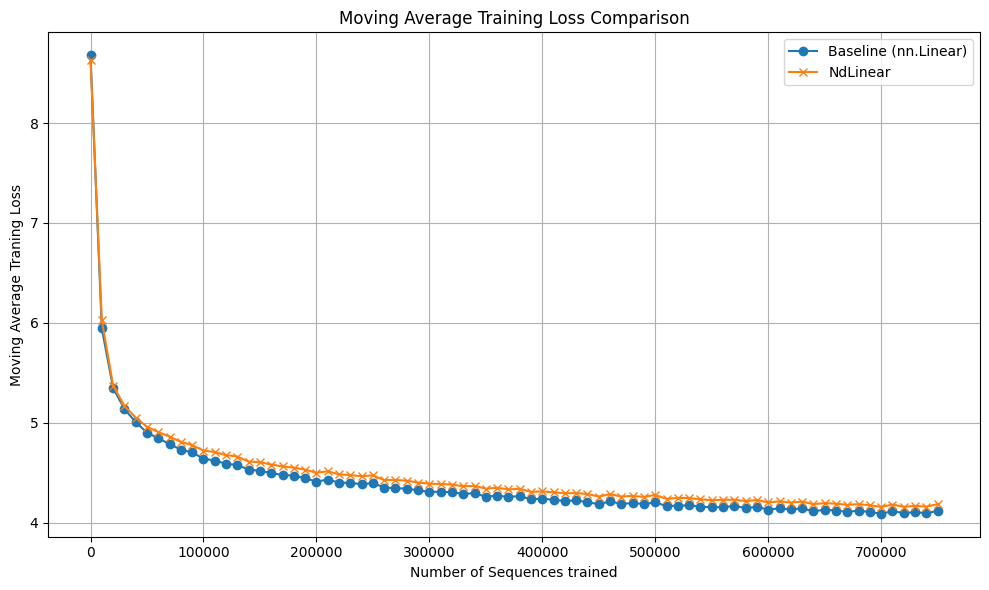

In [ ]:
# import the loss saves
def read_and_get_data_points(file):
    data = []
    try:
        with open(file, 'r') as f:
            for line in f:
                line = line.strip()
                split_data = line.split(',')
                split_data = [float(point) for point in split_data]
                data.append((split_data[0], split_data[1]))
        return data
    except Exception as e:
        print(f"Error {e}")

baseline_data = read_and_get_data_points(root + './intermediate_steps/experiment1-baseline.txt')
ndLinear_data = read_and_get_data_points(root + './intermediate_steps/experiment1-ndlinear.txt')

def plot_loss_curves(baseline_data, ndlinear_data=None):
    plt.figure(figsize=(10, 6))

    baseline_loss, baseline_steps = zip(*baseline_data)
    plt.plot(baseline_steps, baseline_loss, label='Baseline (nn.Linear)', marker='o')

    nd_loss, nd_steps = zip(*ndlinear_data)
    plt.plot(nd_steps, nd_loss, label='NdLinear', marker='x')

    plt.xlabel('Number of Sequences trained')
    plt.ylabel('Moving Average Traning Loss')
    plt.title('Moving Average Training Loss Comparison')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_loss_curves(baseline_data, ndLinear_data)

### Validation Set Evaluation
- validate on our validation set of 5000 English Chinese Pairs

In [ ]:
def eval_model_loss(encoder, decoder, dataset, device='cuda'):
    encoder.to(device).eval()
    decoder.to(device).eval()

    total_loss = 0.0
    with torch.no_grad():
        for pair in dataset:
            en_tensor = sequence_to_tensor_en(pair['english']).to(device)
            zh_tensor = sequence_to_tensor_zh(pair['chinese']).to(device)

            enc_out, enc_hidden = encoder(en_tensor)
            logits = decoder(enc_hidden, encoder_out=enc_out,
                             sentence=zh_tensor[:-1])
            loss = nn.functional.cross_entropy(torch.squeeze(logits),
                                   zh_tensor[1:])
            total_loss += loss.item()

    return total_loss / len(dataset)


def eval_both_models(val_set_mini, device='cuda'):
    baseline_loss = eval_model_loss(baseline_encoder,
                                    baseline_decoder,
                                    val_set_mini,
                                    device)
    ndlinear_loss = eval_model_loss(encoder,
                                    decoder,
                                    val_set_mini,
                                    device)
    return {'baseline_loss': baseline_loss,
            'ndlinear_loss': ndlinear_loss}

In [ ]:
results = eval_both_models(val_set_mini, device=device)
print(results)

{'baseline_loss': 4.145205274963379, 'ndlinear_loss': 4.214421719765663}


## 'Vibes' Evaluation
- Evaluate both models on general translation 'vibes'.
- As a Chinese speaker, I will evaluate both models on simple sentences, and for each translation, choose which one is better

In [ ]:
sentences = [
    "I love to eat.",
    "My best friend's friend is your friend.",
    "The apple doesn't fall far from the tree",
    "He cried tears of joy",
    "Do not forget.",
    "I spy with my little eye.",
    "What is your name?",
    "I hate apples.",
    "Is this the end?",
    "I am finally done with work."
]
def vibes_test():
    for idx, sentence in enumerate(sentences):
        print(f"Sentence {idx + 1}")
        print("nn.Linear:")
        translate(baseline_encoder, baseline_decoder, sentence, device=device)
        print("NdLinear:")
        translate(encoder, decoder, sentence, device=device)
vibes_test()

Sentence 1
nn.Linear:
我爱吃吃饭<EOS>
NdLinear:
我爱我喜欢<EOS>
Sentence 2
nn.Linear:
我的最好朋友朋友朋友<EOS>
NdLinear:
我的朋友是朋友朋友<EOS>
Sentence 3
nn.Linear:
苹果不会从树上的树子<EOS>
NdLinear:
苹果不远远远远远远远远远远远远远远远远远
Sentence 4
nn.Linear:
他是泪的泪<EOS>
NdLinear:
他哭泣的泪<EOS>
Sentence 5
nn.Linear:
不要忘记<EOS>
NdLinear:
不要忘记<EOS>
Sentence 6
nn.Linear:
我的小眼睛我的眼睛<EOS>
NdLinear:
我的小眼睛我的眼睛<EOS>
Sentence 7
nn.Linear:
你是什么名字<EOS>
NdLinear:
你的名字是什么<EOS>
Sentence 8
nn.Linear:
我讨厌的<EOS>
NdLinear:
我恨我们我喜欢苹果<EOS>
Sentence 9
nn.Linear:
这是这个这是这个这个这个这是这个这个这个
NdLinear:
这是这个图书<EOS>
Sentence 10
nn.Linear:
我最终在做了工作<EOS>
NdLinear:
我最后一个工作<EOS>


### Vibes Test Results:

- nn.Linear did better on 5/10 sentences (1, 2, 8, 9 10).
- NdLinear did better on 3/10 sentences (3, 4, 7).
- They did the same on 2/10 sentences (5, 6)

## Conclusion

The NdLinear approach employed in this experiment represents a large reduction in the parameter count of the output projection linear layer. Given that the reduction is ~50%:

$$
2 H × V = 2 * 128 * 5818 = 1,489,408
$$

vs.

$$
(2 * 1) + (H * V) = 2 + (128 * 5818) = 744,706
$$

It would not be surprising to see a significant drop in model performance in the NdLinear version. This is especially true given the importance of this projection layer as it is the layer that learns the mapping from decoder LSTM outputs to words in the vocabulary.

However, from the results of the experiment we can see that the NdLinear layer, even with 50% of the parameters of the baseline layer, performs similarly. In terms of rate of learning and convergence, from the moving average training loss graph, we can see that NdLinear trails slightly behind the nn.Linear version, but at the end of epoch 3 the difference is very small, at 0.062.

Looking at the performance on the validation set, we can see that the NdLinear experiment performs only slightly worse, a difference of 0.0692 on average for cross entropy loss. This small difference is not really significant enough to tell a qualitative difference in translation quality. This is supported by our "vibes" translation test, in which the NdLinear model actually seems to have better translations in 3/10
(sentence 3, 4, 7) examples, and exactly the same in 2/10 examples (5, 6).

These results suggest that for a 750 k-pair dataset, replacing nn.Linear(2 H, V) with NdLinear((2, H),(1, V)) can cut projection weights by ≈50 % without a noticeable loss in translation quality. Future work should confirm this on larger dataset and report BLEU score for a more rigorous comparison.

### Ideas for further research

One natural next step would be to evaluate an NdLinear layer with the same number of parameters as the standard nn.Linear layer. Given that the NdLinear layer performed comparably even with 50% fewer parameters, it would not be surprising if a parameter matched NdLinear layer outperformed the baseline due to its structured design.

Another interesting direction would be to extend the use of higher dimensional inputs. In this experiment, we used an input shape of (2, hidden_dim). Future studies could experiment with reshaping inputs into even higher-dimensional matrices—such as (4, hidden_dim // 2) or (2, 2, hidden_dim // 2)—to explore whether the model can learn something interesting from this artificial structure.

Finally, it would be interesting to scale this experiment to a larger dataset to assess whether the observed benefits of NdLinear hold under more demanding training conditions. Larger datasets and longer training schedules could reveal further differences in generalization and convergence.

Thanks for reading, this was a really interesting experiment :)